In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from pandas.tseries.offsets import MonthBegin
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix

In [23]:
df_agg = pd.read_pickle('./df_agg.pkl')

In [24]:
df_agg_test = df_agg.loc[df_agg['contract_start_year_month'] >= '2017-05-01', :]
df_agg_train = df_agg.loc[df_agg['contract_start_year_month'] < '2017-05-01', :]

In [25]:
corr_matrix = df_agg_train.drop(['contract_start_year_month', 'rental_revenue', 'total_days_rented', 'avg_price_per_day'], axis=1).corr()
corr_matrix['units_rented'].sort_values(ascending=False)

units_rented                     1.000000
same_month_avg_units_rented      0.944009
same_month_avg_days_rented       0.891598
prior_month_units_rented         0.818546
prior_month_total_days_rented    0.779496
product_type_20-220              0.576089
prior_month_rental_revenue       0.392601
rental_type_monthly              0.328883
product_type_20-240              0.239279
product_type_20-720              0.111007
product_type_20-270              0.062830
product_type_20-530              0.040687
product_type_20-210              0.038352
product_type_20-847              0.030308
contract_start_month_11          0.015864
contract_start_month_10          0.015415
product_type_20-170              0.014998
product_type_20-740              0.010674
product_type_20-580              0.006522
contract_start_month_6           0.006435
contract_start_month_3           0.005548
product_type_20-810              0.005224
contract_start_month_12          0.004407
contract_start_month_7           0

In [26]:
features = ['units_rented', 'prior_month_units_rented', 'prior_month_total_days_rented', 'same_month_avg_units_rented', 'same_month_avg_days_rented', 'prior_month_rental_revenue']

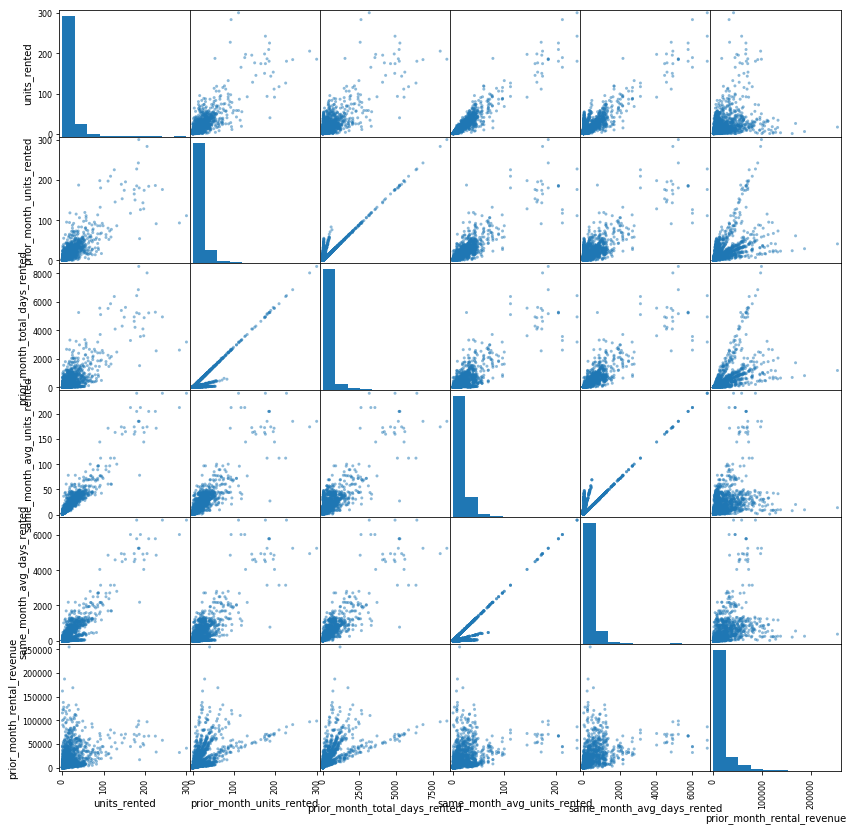

In [27]:
scatter_matrix(df_agg_train[features], figsize=(14,14));

In [28]:
X_train = df_agg_train.drop(['units_rented', 'contract_start_year_month', 'rental_revenue', 'total_days_rented', 'avg_price_per_day'], axis=1).values
y_train = df_agg_train['units_rented'].values
X_test = df_agg_test.drop(['units_rented', 'contract_start_year_month', 'rental_revenue', 'total_days_rented', 'avg_price_per_day'], axis=1).values
y_test = df_agg_test['units_rented'].values
standardizer = StandardScaler()
standardizer.fit(X_train, y_train)
X_train_std = standardizer.transform(X_train)
X_test_std = standardizer.transform(X_test)

In [29]:
X_train_std_wconst = sm.add_constant(X_train_std)
ols = sm.OLS(y_train, X_train_std_wconst).fit()
ols_res = ols.outlier_test()[:,0]
y_fitted = ols.fittedvalues

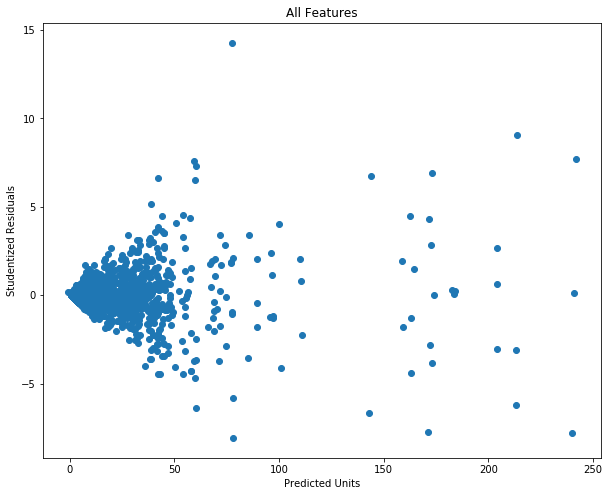

In [30]:
fig1 = plt.figure(figsize = (10,8))
ax1 = fig1.add_subplot(111)
ax1.scatter(y_fitted, ols_res)
ax1.set_xlabel('Predicted Units')
ax1.set_ylabel('Studentized Residuals')
ax1.set_title('All Features');

In [31]:
## Linear Regression
linear = LinearRegression(n_jobs=-1)
linear.fit(X_train_std, y_train)
y_pred_train_linear = linear.predict(X_train_std)
y_pred_test_linear = linear.predict(X_test_std)

In [32]:
## Random Forest
rf = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1, min_samples_leaf=4, min_samples_split=8)
rf.fit(X_train_std, y_train)
y_pred_train_rf = rf.predict(X_train_std)
y_pred_test_rf = rf.predict(X_test_std)

In [33]:
df_agg_test = pd.read_pickle('./df_agg_test.pkl')

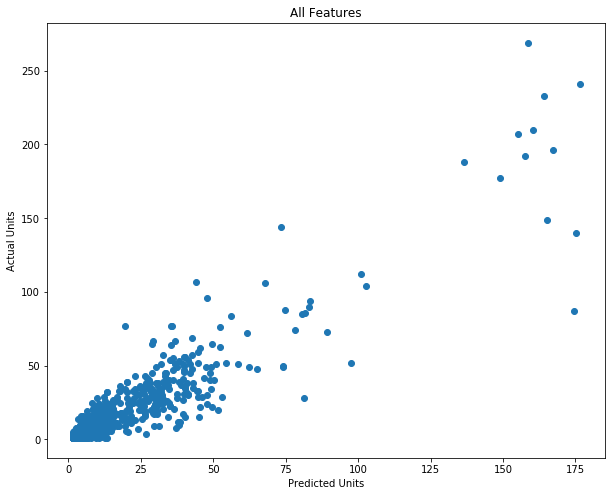

In [46]:
fig2 = plt.figure(figsize = (10,8))
ax1 = fig2.add_subplot(111)
ax1.scatter(df_agg_test['units_rented_pred_rf'], df_agg_test['units_rented'])
ax1.set_xlabel('Predicted Units')
ax1.set_ylabel('Actual Units')
ax1.set_title('All Features');

In [35]:
df_company_units = df_agg_test.groupby(['contract_start_year_month', 'rental_type_daily', 'rental_type_weekly', 'rental_type_monthly']).agg({'rental_revenue':'sum', 'same_month_avg_units_rented':'sum', 'units_rented':'sum', 'units_rented_pred_lin':'sum', 'units_rented_pred_rf':'sum'}).reset_index()
df_company_units_monthly = df_company_units.loc[df_company_units['rental_type_monthly'] == 1, :]
df_company_units_weekly = df_company_units.loc[df_company_units['rental_type_weekly'] == 1, :]
df_company_units_daily = df_company_units.loc[df_company_units['rental_type_daily'] == 1, :]
df_company_units.head()

,contract_start_year_month,rental_type_daily,rental_type_weekly,rental_type_monthly,rental_revenue,same_month_avg_units_rented,units_rented,units_rented_pred_lin,units_rented_pred_rf
0,2017-05-01,0,0,1,890984.999,788.5,998,787.018349,798.917973
1,2017-05-01,0,1,0,216208.000,279.0,273,279.319538,282.692049
2,2017-05-01,1,0,0,143314.000,272.5,335,280.736136,276.473028
3,2017-06-01,0,0,1,1107019.000,804.5,989,799.451943,826.902026
4,2017-06-01,0,1,0,232039.001,292.5,295,293.977647,289.736777


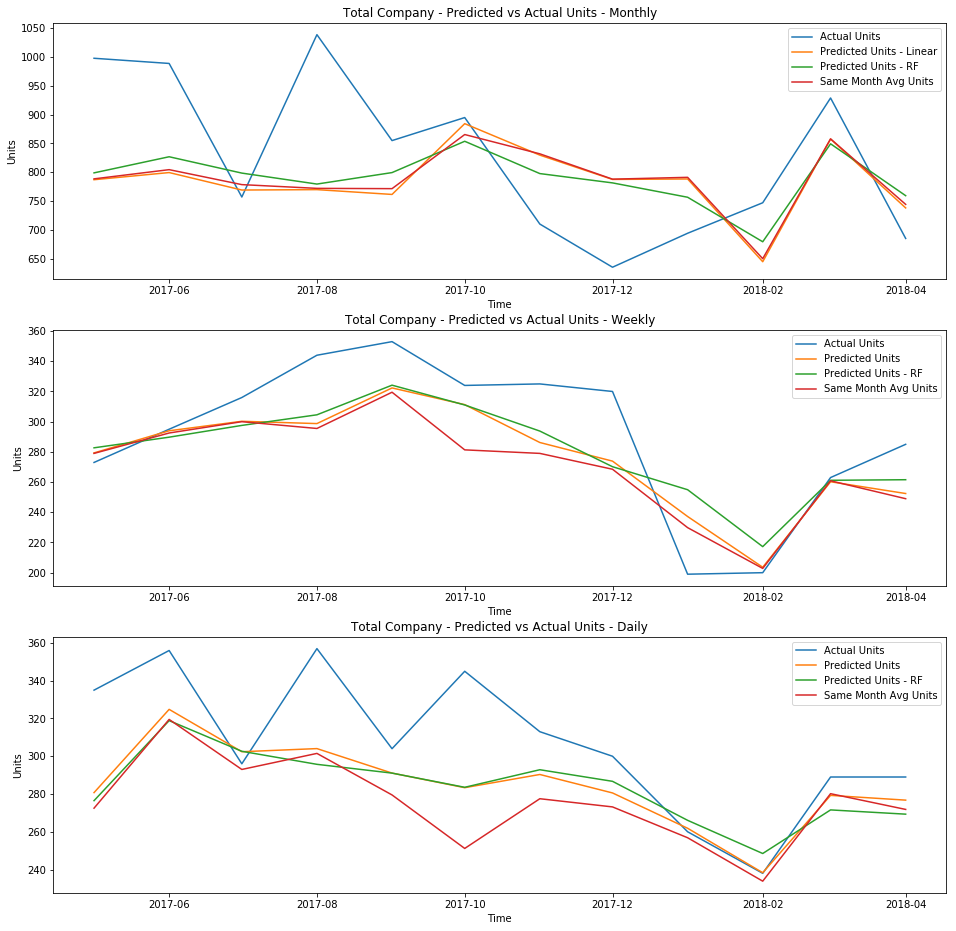

In [39]:
fig3 = plt.figure(figsize = (16,16))
ax1 = fig3.add_subplot(311)
ax2 = fig3.add_subplot(312)
ax3 = fig3.add_subplot(313)

ax1.plot(df_company_units_monthly['contract_start_year_month'], df_company_units_monthly['units_rented'], label='Actual Units')
ax1.plot(df_company_units_monthly['contract_start_year_month'], df_company_units_monthly['units_rented_pred_lin'], label='Predicted Units - Linear')
ax1.plot(df_company_units_monthly['contract_start_year_month'], df_company_units_monthly['units_rented_pred_rf'], label='Predicted Units - RF')
ax1.plot(df_company_units_monthly['contract_start_year_month'], df_company_units_monthly['same_month_avg_units_rented'], label='Same Month Avg Units')
ax1.set_xlabel('Time')
ax1.set_ylabel('Units')
ax1.set_title('Total Company - Predicted vs Actual Units - Monthly')
ax1.legend();

ax2.plot(df_company_units_weekly['contract_start_year_month'], df_company_units_weekly['units_rented'], label='Actual Units')
ax2.plot(df_company_units_weekly['contract_start_year_month'], df_company_units_weekly['units_rented_pred_lin'], label='Predicted Units')
ax2.plot(df_company_units_weekly['contract_start_year_month'], df_company_units_weekly['units_rented_pred_rf'], label='Predicted Units - RF')
ax2.plot(df_company_units_weekly['contract_start_year_month'], df_company_units_weekly['same_month_avg_units_rented'], label='Same Month Avg Units')
ax2.set_xlabel('Time')
ax2.set_ylabel('Units')
ax2.set_title('Total Company - Predicted vs Actual Units - Weekly')
ax2.legend();

ax3.plot(df_company_units_daily['contract_start_year_month'], df_company_units_daily['units_rented'], label='Actual Units')
ax3.plot(df_company_units_daily['contract_start_year_month'], df_company_units_daily['units_rented_pred_lin'], label='Predicted Units')
ax3.plot(df_company_units_daily['contract_start_year_month'], df_company_units_daily['units_rented_pred_rf'], label='Predicted Units - RF')
ax3.plot(df_company_units_daily['contract_start_year_month'], df_company_units_daily['same_month_avg_units_rented'], label='Same Month Avg Units')
ax3.set_xlabel('Time')
ax3.set_ylabel('Units')
ax3.set_title('Total Company - Predicted vs Actual Units - Daily')
ax3.legend();

In [41]:
df_20_220_units = df_agg_test.loc[df_agg_test['product_type_20-220'] == 1,:]
df_20_220_units_monthly = df_20_220_units.loc[df_20_220_units['rental_type_monthly'] == 1, :]
df_20_220_units_weekly = df_20_220_units.loc[df_20_220_units['rental_type_weekly'] == 1, :]
df_20_220_units_daily = df_20_220_units.loc[df_20_220_units['rental_type_daily'] == 1, :]
df_20_220_units.head()

,contract_start_year_month,rental_revenue,total_days_rented,units_rented,avg_price_per_day,prior_month_rental_revenue,prior_month_total_days_rented,prior_month_units_rented,prior_month_avg_price_per_day,same_month_avg_units_rented,...,contract_start_month_8,contract_start_month_9,contract_start_month_10,contract_start_month_11,contract_start_month_12,rental_type_daily,rental_type_monthly,rental_type_weekly,units_rented_pred_lin,units_rented_pred_rf
2623,2017-05-01,7369.000,264.000,34,27.912879,10622.000,378.000,49.0,28.100529,49.5,...,0,0,0,0,0,0,0,1,50.091703,49.366986
2643,2017-05-01,8336.000,79.000,57,105.518987,5672.000,59.000,48.0,96.135593,42.5,...,0,0,0,0,0,1,0,0,43.881341,42.638846
2644,2017-05-01,85158.999,6591.928,233,12.918679,70812.000,5789.896,205.0,12.230271,172.5,...,0,0,0,0,0,0,1,0,171.746575,164.136620
2742,2017-06-01,10563.000,348.000,45,30.353448,7369.000,264.000,34.0,27.912879,52.5,...,0,0,0,0,0,0,0,1,51.615140,48.725628
2754,2017-06-01,74507.000,5989.928,210,12.438714,85158.999,6591.928,233.0,12.918679,164.5,...,0,0,0,0,0,0,1,0,162.801263,160.322130


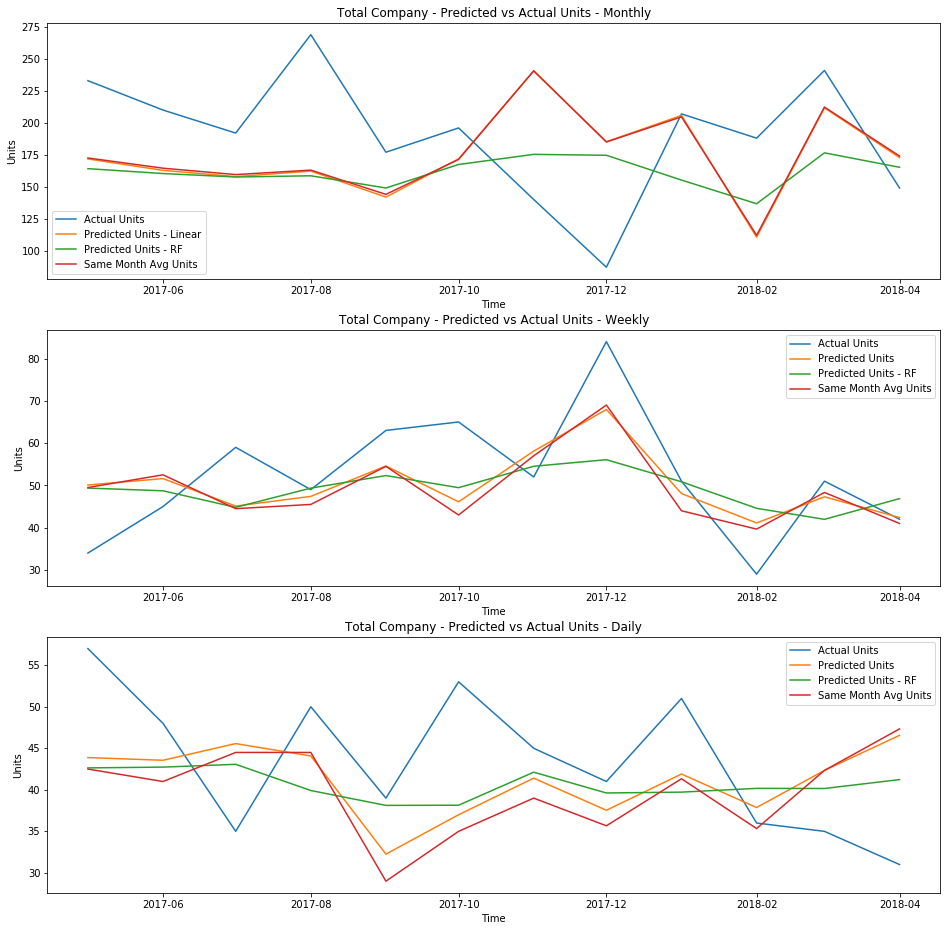

In [44]:
fig3 = plt.figure(figsize = (16,16))
ax1 = fig3.add_subplot(311)
ax2 = fig3.add_subplot(312)
ax3 = fig3.add_subplot(313)

ax1.plot(df_20_220_units_monthly['contract_start_year_month'], df_20_220_units_monthly['units_rented'], label='Actual Units')
ax1.plot(df_20_220_units_monthly['contract_start_year_month'], df_20_220_units_monthly['units_rented_pred_lin'], label='Predicted Units - Linear')
ax1.plot(df_20_220_units_monthly['contract_start_year_month'], df_20_220_units_monthly['units_rented_pred_rf'], label='Predicted Units - RF')
ax1.plot(df_20_220_units_monthly['contract_start_year_month'], df_20_220_units_monthly['same_month_avg_units_rented'], label='Same Month Avg Units')
ax1.set_xlabel('Time')
ax1.set_ylabel('Units')
ax1.set_title('Total Company - Predicted vs Actual Units - Monthly')
ax1.legend();

ax2.plot(df_20_220_units_weekly['contract_start_year_month'], df_20_220_units_weekly['units_rented'], label='Actual Units')
ax2.plot(df_20_220_units_weekly['contract_start_year_month'], df_20_220_units_weekly['units_rented_pred_lin'], label='Predicted Units')
ax2.plot(df_20_220_units_weekly['contract_start_year_month'], df_20_220_units_weekly['units_rented_pred_rf'], label='Predicted Units - RF')
ax2.plot(df_20_220_units_weekly['contract_start_year_month'], df_20_220_units_weekly['same_month_avg_units_rented'], label='Same Month Avg Units')
ax2.set_xlabel('Time')
ax2.set_ylabel('Units')
ax2.set_title('Total Company - Predicted vs Actual Units - Weekly')
ax2.legend();

ax3.plot(df_20_220_units_daily['contract_start_year_month'], df_20_220_units_daily['units_rented'], label='Actual Units')
ax3.plot(df_20_220_units_daily['contract_start_year_month'], df_20_220_units_daily['units_rented_pred_lin'], label='Predicted Units')
ax3.plot(df_20_220_units_daily['contract_start_year_month'], df_20_220_units_daily['units_rented_pred_rf'], label='Predicted Units - RF')
ax3.plot(df_20_220_units_daily['contract_start_year_month'], df_20_220_units_daily['same_month_avg_units_rented'], label='Same Month Avg Units')
ax3.set_xlabel('Time')
ax3.set_ylabel('Units')
ax3.set_title('Total Company - Predicted vs Actual Units - Daily')
ax3.legend();

In [48]:
df_agg_test.loc[:, 'residuals_rf'] = df_agg_test['units_rented'] - df_agg_test['units_rented_pred_rf']

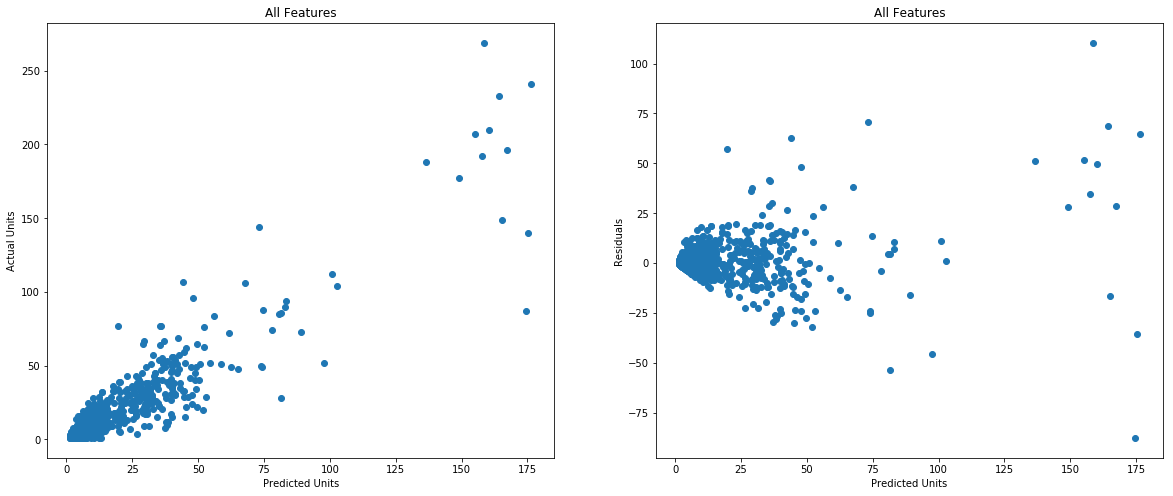

In [57]:
fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(121)
ax1.scatter(df_agg_test['units_rented_pred_rf'], df_agg_test['units_rented'])
ax1.set_xlabel('Predicted Units')
ax1.set_ylabel('Actual Units')
ax1.set_title('All Features')

ax2 = fig.add_subplot(122)
ax2.scatter(df_agg_test['units_rented_pred_rf'], df_agg_test['residuals_rf'])
ax2.set_xlabel('Predicted Units')
ax2.set_ylabel('Residuals')
ax2.set_title('All Features');

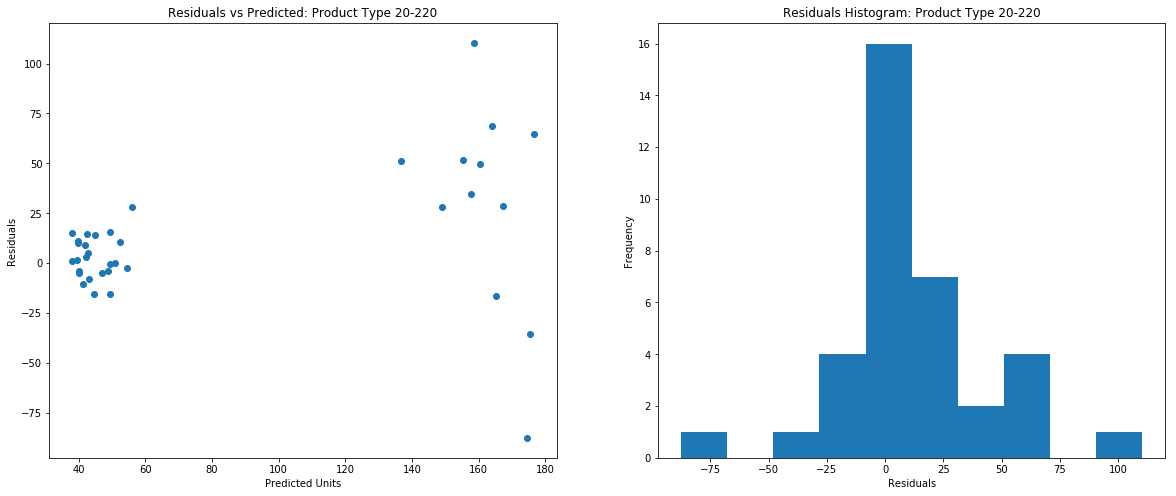

In [70]:
fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(121)
ax1.scatter(df_agg_test.loc[df_agg_test['product_type_20-220'] == 1, 'units_rented_pred_rf'], df_agg_test.loc[df_agg_test['product_type_20-220'] == 1, 'residuals_rf'])
ax1.set_xlabel('Predicted Units')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted: Product Type 20-220')

ax2 = fig.add_subplot(122)
ax2.hist(df_agg_test.loc[df_agg_test['product_type_20-220'] == 1, 'residuals_rf'], bins=10)
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Frequency')
ax2.set_title('Residuals Histogram: Product Type 20-220');